# Visualizing Explanation Artifacts
We define explanation artifacts for mask explanations as <u>artificial edges in the explanation that do not occur in the original image</u>. In this notebook we will visualize explanation artifacts in <u>ShearletX</u> (ours), <u>WaveletX</u> (ours), <u>Pixel Mask without Smoothness Constraints</u>, and [Smoothmask](https://www.robots.ox.ac.uk/~vedaldi/assets/pubs/fong19understanding.pdf).

In [1]:
import os
import sys
sys.path.insert(0,'./..')

from shearletx import ShearletX
from waveletx import WaveletX
from smoothmask import SmoothMask
from pixelmask import PixelMask
from functools import partial

from imagenet_utils.data import Imagenet
from imagenet_utils.imagenet_labels import imagenet_labels_dict
from shearlet_edge_detector import get_shearlet_based_edges

from torchray.attribution.extremal_perturbation import extremal_perturbation, contrastive_reward
from torchray.benchmark import get_example_data, plot_example
from torchray.utils import get_device

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from PIL import Image
import time

import torch
from torchvision import transforms
import torchvision.models as models
import kornia
import cv2 as cv
import torch.nn as nn
from pytorch_wavelets import DWTForward, DWTInverse

plt.rcParams.update()
matplotlib.rcParams['font.family'] = "serif"

def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

    
# Set random seed for reproducibility
seed_everything(42)

/home/groups/ai/kolek/miniconda3/envs/scat/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Get Model
We will use the [MobilenetV3](https://arxiv.org/pdf/1905.02244v5.pdf) network in this notebook.

In [2]:
# Get device
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Define input normalization layer for imagenet images
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean, device=device, requires_grad=False)
        self.std = torch.tensor(std, device=device, requires_grad=False)

    def forward(self, x):
        x = x - self.mean.reshape(self.mean.size(0),1,1)
        x = x / self.std.reshape(self.std.size(0),1,1)
        return x

# Get model
network = models.mobilenet_v3_small(pretrained=True).eval().to(device)
model = nn.Sequential(Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), network)    

# Weights do not require grads for this experiment
for param in model.parameters():
    param.requires_grad = False

### Load Image
We will load an image of a barn and visualize the explanation artifacts for the classification decision of a [MobilenetV3](https://arxiv.org/pdf/1905.02244v5.pdf) network.

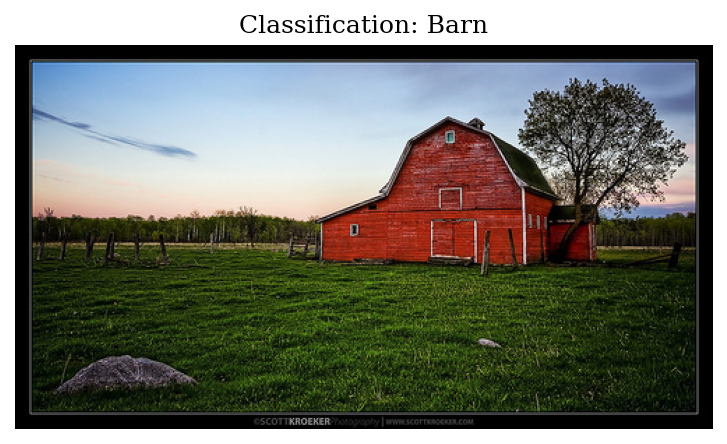

In [3]:
convert_to_tensor = transforms.Compose(
    [transforms.ToTensor(), transforms.Resize(size=(256,256))]
)
    

img = Image.open(os.path.join('imgs', 'ILSVRC2012_val_00000234.JPEG')).convert('RGB')
# Convert image to tensor
x = convert_to_tensor(img).unsqueeze(0).to(device)
# Get prediction for x
preds = nn.Softmax(dim=-1)(model(x)).max(1)[1].detach()

# Plot the image
plt.subplots(dpi=150)
plt.imshow(img)
plt.axis('off')
plt.title('Classification: '+imagenet_labels_dict[preds[0].item()].split(',')[0].capitalize())


# Show the plot
plt.show()


### Compute Explanations
We compute the explanations with <u>ShearletX</u> (ours), <u>WaveletX</u> (ours), <u>Pixel Mask without Smoothness Constraints</u>, and [Smoothmask](https://www.robots.ox.ac.uk/~vedaldi/assets/pubs/fong19understanding.pdf).


In [4]:
# Hparams WaveletX 
WAVELETX_HPARAMS = {"l1lambda": 2., "lr": 1e-1, 'obfuscation': 'uniform', 'maximize_label': True,
          "optim_steps": 150,  "noise_bs": 16, 'l1_reg': 35., 'mask_init': 'ones'} 

# Hparams ShearletX
SHEARLETX_HPARAMS = {"l1lambda": 1., "lr": 1e-1, 'obfuscation': 'uniform', 'maximize_label': True,
          "optim_steps": 150,  "noise_bs": 16, 'l1_reg': 1., 'mask_init': 'ones'} 

# Hparams Pixel Mask without smoothness constraints
HPARAMS_PIXELMASK = {"l1lambda": 1., "lr": 1e-1, 'obfuscation': 'uniform', 'maximize_label': True,
  "optim_steps": 150,  "noise_bs": 16, 'tv_reg': 0., 'mask_init': 'ones'} 

In [5]:
# Compute ShearletX
print(f'=================> Computing ShearletX...\n')
shearletx_method = ShearletX(model=model, device=device, **SHEARLETX_HPARAMS)
shearletx, history_shearletx = shearletx_method(x, preds)
shearletx = shearletx/shearletx.max()

# Compute WaveletX 
print(f'\n=================> Computing WaveletX...\n')
waveletx_method = WaveletX(model=model, device=device, **WAVELETX_HPARAMS)
waveletx, history_waveletx = waveletx_method(x, preds)
waveletx = waveletx/waveletx.max()

# Compite Smoothmask
print(f'\n=================> Computing Smooth Mask...\n')
area = 0.2 # How much area should be kept by smoothmask
smoothmask_method = SmoothMask(area, model)
smoothmask = smoothmask_method(x, preds[0].item())

# Compute Pixel Mask (without smoothness constraints)
print(f'\n=================> Computing Pixel Mask...\n')
pixelmask_method = PixelMask(model=model, device=device, **HPARAMS_PIXELMASK)
pixelmask, history_pixelmask = pixelmask_method(x, preds)

=================> Computing ShearletX...

Iter 149/150
=================> Computing WaveletX...

Iter 149/150
=================> Computing Smooth Mask...


=================> Computing Pixel Mask...

Iter 149/150

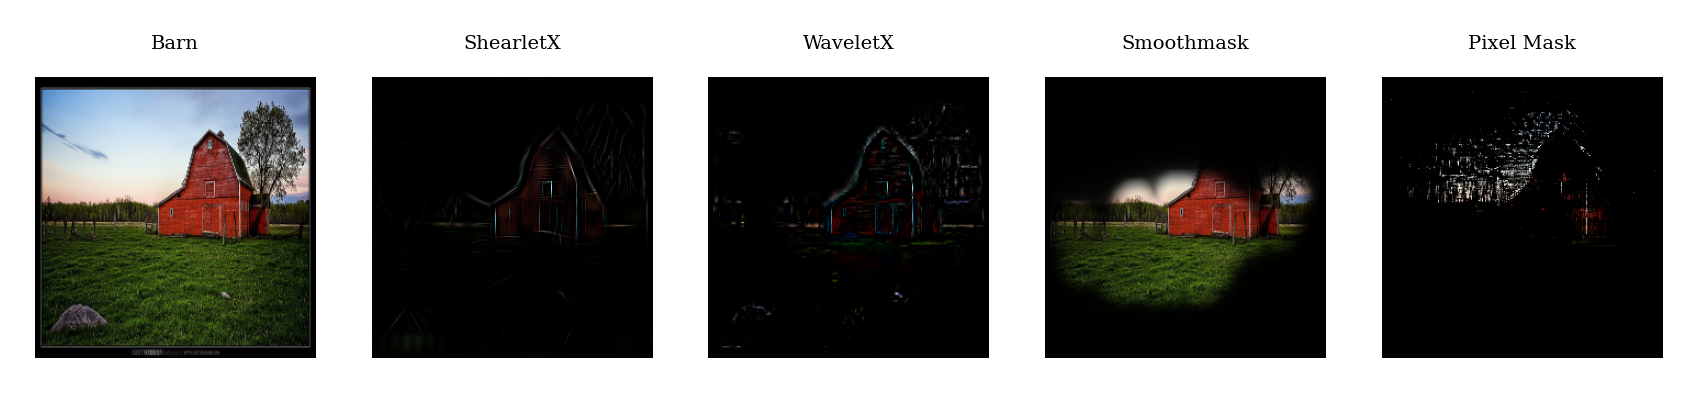

In [6]:
# ============================== Plot Explanation ==============================
fig, axs = plt.subplots(1,5, dpi=350)
s = 4 # fontsize
# Input Image
axs[0].imshow(x.squeeze(0).permute(1,2,0).cpu())
axs[0].set_title(imagenet_labels_dict[preds[0].item()].split(',')[0].capitalize(), fontsize=s)
axs[0].axis('off')

# ShearletX Visualization
axs[1].imshow(shearletx.squeeze(0).permute(1,2,0).cpu())
axs[1].axis('off')
axs[1].set_title('ShearletX', fontsize=s)

# WaveletX Visualization
axs[2].imshow(waveletx.squeeze(0).permute(1,2,0).cpu())
axs[2].axis('off')
axs[2].set_title('WaveletX', fontsize=s)


# Smoothmask Visualization
axs[3].imshow(smoothmask.squeeze(0).permute(1,2,0).cpu())
axs[3].axis('off')
axs[3].set_title('Smoothmask', fontsize=s
)


# PixelMask Visualization
axs[4].imshow(pixelmask.squeeze(0).permute(1,2,0).cpu())
axs[4].axis('off')
axs[4].set_title('Pixel Mask', fontsize=s)
plt.show()

### Computing Edges in Image and Explanation
We compute the <u>edges in the orginial barn image</u> (later marked green) and <u>edges in each explanation</u>. The edges that occur in the explanation but not in the original barn image (later marked red) are explanation artifacts and quantified by the <u>Hallucination Score</u>.

To extract the edges, we use a [shearlet based edge detector](https://github.com/rgcda/PyCoShREM), which we find to work better than the popular [Canny edge detector](https://en.wikipedia.org/wiki/Canny_edge_detector). 

When computing the edges that occur in the explanation but not the original image we slightly <u>dilate the edges</u> in case edge pixels differ by very few pixels. 

In [7]:
# Parameters for edge detector
threshold, upper, lower = 0.1, 1, 0
edge_extractor = partial(get_shearlet_based_edges, min_contrast=3)

# Get edges in original image
edges_x = edge_extractor((x.sum(dim=1, keepdim=True)/3).cpu())
edges_x = torch.where(edges_x>threshold, upper, lower)
dilation, kernel = kornia.morphology.dilation, torch.ones(3,3)
edges_x_dilated = dilation(edges_x.unsqueeze(1), kernel).squeeze(1)

# Get edges in ShearletX
edges_shearletx = edge_extractor((shearletx.sum(dim=1, keepdim=True)/3).cpu())
edges_shearletx = torch.where(edges_shearletx>threshold, upper, lower)
edge_intersection_shearletx = edges_shearletx - edges_x_dilated
hallu_score_shearletx = (edge_intersection_shearletx==1).sum(dim=[-1,-2])/(edges_x==1).sum(dim=[-1,-2])
vis_edges_shearletx = edges_x.clone() # edges in batch that are not in explanation have val 1
vis_edges_shearletx[edges_shearletx==1] = 2 # marked correct edges have val 2
vis_edges_shearletx[edge_intersection_shearletx==1] = 3 # hallucinations have val 3


# Get edges in WaveletX
edges_waveletx = edge_extractor((waveletx.sum(dim=1,keepdim=True)/3).cpu())
edges_waveletx = torch.where(edges_waveletx>threshold, upper, lower)
edge_intersection_waveletx = edges_waveletx - edges_x_dilated
hallu_score_waveletx = (edge_intersection_waveletx==1).sum(dim=[-1,-2])/(edges_x==1).sum(dim=[-1,-2])
vis_edges_waveletx = edges_x.clone() # edges in batch that are not in explanation have val 1
vis_edges_waveletx[edges_waveletx==1] = 2 # marked correct edges have val 2
vis_edges_waveletx[edge_intersection_waveletx==1] = 3 # hallucinations have val 3


# Get edges in Smooth Mask
edges_smoothmask =  edge_extractor(smoothmask.cpu().sum(dim=1,keepdim=True)/3)
edges_smoothmask =  torch.where(edges_smoothmask>threshold, upper, lower)
edge_intersection_smoothmask = edges_smoothmask - edges_x_dilated
hallu_score_smoothmask = (edge_intersection_smoothmask==1).sum(dim=[-1,-2])/(edges_x==1).sum(dim=[-1,-2])
vis_edges_smoothmask = edges_x.clone() # edges in batch that are not in explanation have val 1
vis_edges_smoothmask[edges_smoothmask==1] = 2 # marked correct edges have val 2
vis_edges_smoothmask[edge_intersection_smoothmask==1] = 3 # hallucinations have val 3


# Get edges in Pixel Mask (without smoothness constraints)
edges_pixelmask = edge_extractor((pixelmask.sum(dim=1, keepdim=True)/3).cpu())
edges_pixelmask = torch.where(edges_pixelmask>threshold, upper, lower)
edge_intersection_pixelmask = edges_pixelmask - edges_x_dilated
hallu_score_pixelmask = (edge_intersection_pixelmask==1).sum(dim=[-1,-2])/(edges_x==1).sum(dim=[-1,-2])
vis_edges_pixelmask = edges_x.clone() # edges in batch that are not in explanation have val 1
vis_edges_pixelmask[edges_pixelmask==1] = 2 # marked correct edges have val 2
vis_edges_pixelmask[edge_intersection_pixelmask==1] = 3 # hallucinations have val 3




Processing Edges


Processing Edges


Processing Edges


Processing Edges


Processing Edges



### Visualize Explanation Artifacts
- <span style="color:red;">Artifacts</span> (edges in explanation but not in original image) are marked in red
- <span style="color:green;">Relevant edges</span> (edges in explanation and original image) are marked in green 
- <span style="color:gray;">Irrelevant edges</span> (edges not in explanation but in original image) are marked white

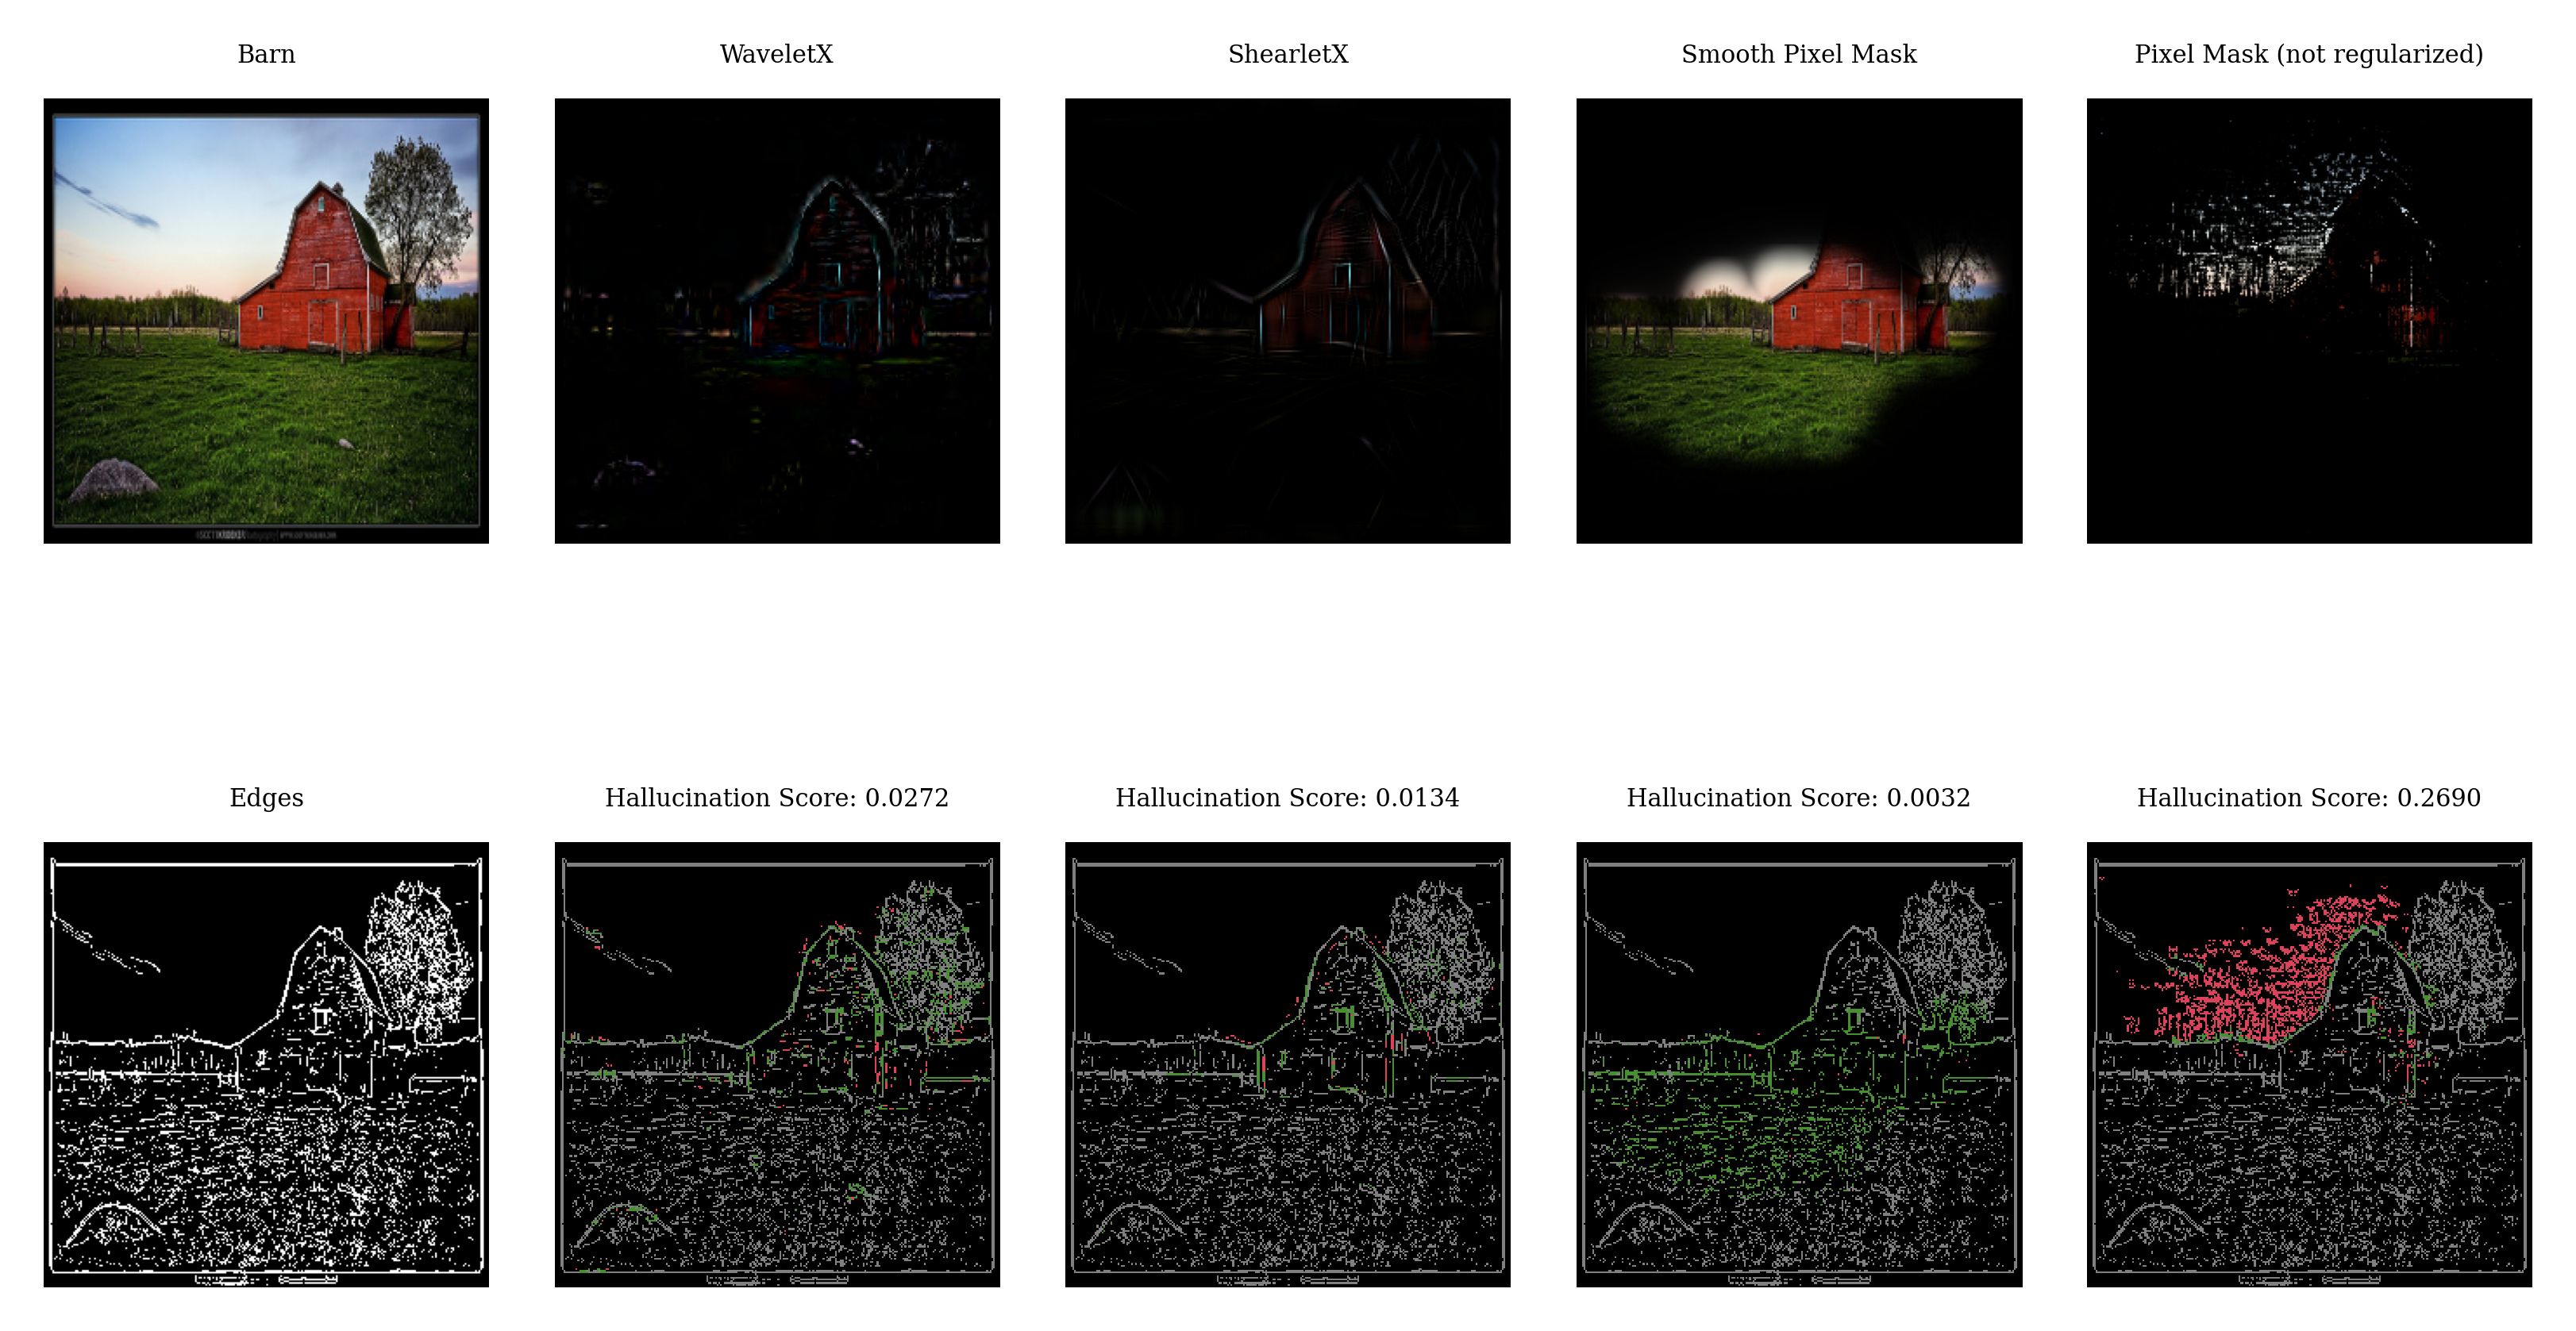

In [9]:
# Make matplotlib figure for each image in batch
fig, axs = plt.subplots(2,5, dpi=550)
s = 4
axs[0,0].imshow(x.squeeze(0).permute(1,2,0).cpu().numpy())
axs[0,0].axis('off')
axs[0,0].set_title(imagenet_labels_dict[preds[0].item()].split(',')[0].capitalize(), fontsize=s)

axs[0,1].imshow(waveletx.squeeze(0).permute(1,2,0).cpu().numpy())
axs[0,1].axis('off')
axs[0,1].set_title('WaveletX', fontsize=s)

axs[0,2].imshow(shearletx.cpu().squeeze(0).permute(1,2,0))
axs[0,2].axis('off')
axs[0,2].set_title('ShearletX', fontsize=s)

axs[0,3].imshow(smoothmask.squeeze(0).permute(1,2,0).cpu().numpy(), cmap="gray")
axs[0,3].axis('off')
axs[0,3].set_title(f'Smooth Pixel Mask', fontsize=s)

axs[0,4].imshow(pixelmask.squeeze(0).permute(1,2,0).cpu().numpy(), cmap="gray")
axs[0,4].axis('off')
axs[0,4].set_title('Pixel Mask (not regularized)', fontsize=s)

cmap = colors.ListedColormap(['black', 'gray', '#488f31', '#de425b'])
bounds = [0, 0.5, 1.5, 2.5, 3.5]
norm = colors.BoundaryNorm(bounds, cmap.N)
plot_args = {'cmap': cmap, 'norm': norm, 'interpolation': 'none'}

axs[1,0].imshow(edges_x.squeeze(0).cpu().numpy(), cmap='gray')
axs[1,0].axis('off')
axs[1,0].set_title(f'Edges', fontsize=s)

axs[1,1].imshow(vis_edges_waveletx.squeeze(0).cpu().numpy(), **plot_args)
axs[1,1].axis('off')
axs[1,1].set_title(f'Hallucination Score: {hallu_score_waveletx[0].item():.4f}', fontsize=s)

axs[1,2].imshow(vis_edges_shearletx[0].squeeze(0).cpu().numpy(), **plot_args)
axs[1,2].axis('off')
axs[1,2].set_title(f'Hallucination Score: {hallu_score_shearletx[0].item():.4f}', fontsize=s)

axs[1,3].imshow(vis_edges_smoothmask.squeeze(0).cpu().numpy(), **plot_args)
axs[1,3].axis('off')
axs[1,3].set_title(f'Hallucination Score: {hallu_score_smoothmask[0].item():.4f}', fontsize=s)

axs[1,4].imshow(vis_edges_pixelmask.squeeze(0).cpu().numpy(), **plot_args)
axs[1,4].axis('off')
axs[1,4].set_title(f'Hallucination Score: {hallu_score_pixelmask.item():.4f}', fontsize=s)

plt.tight_layout()
plt.savefig(f'../imgs/explanation_artifacts.png',bbox_inches='tight',pad_inches = 0, dpi=400)
plt.show()